# Isophotes and Deblending

Relevant photutils websites:

https://photutils.readthedocs.io/en/stable/morphology.html

https://photutils.readthedocs.io/en/stable/isophote.html

https://photutils.readthedocs.io/en/stable/segmentation.html

In [1]:
import os
import numpy as np
from glob import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from astropy.stats import SigmaClip, sigma_clipped_stats, mad_std
from photutils import aperture_photometry, CircularAperture, CircularAnnulus 
from photutils import Background2D, MedianBackground
from astropy.modeling.models import Gaussian2D
from photutils.datasets import make_noise_image
# %matplotlib notebook

import jupyterthemes as jt
jt.jtplot.style()


In [2]:
def fake_galaxy(x0,y0,amplitude,asemi,bsemi,theta,npix=150):
    """ x0, y0, amplitude, asemi, bsemi, theta (deg), npix wide"""
    g = Gaussian2D(amplitude, x0, y0, asemi, bsemi, theta=np.deg2rad(theta))
    ny = nx = npix
    y, x = np.mgrid[0:npix, 0:npix]
    noise = make_noise_image((ny, nx), distribution='gaussian', mean=0., stddev=2.)
    data = g(x, y) + noise
    return data

In [3]:
data = fake_galaxy(75,75,100.0,20,12,40)

(-0.5, 149.5, -0.5, 149.5)

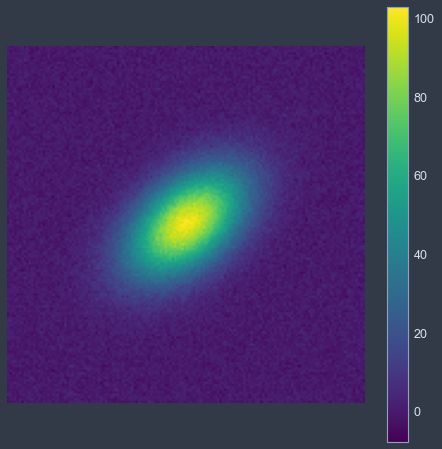

In [4]:
fig = plt.figure(figsize=(8,8))
plt.imshow(data,origin='lower')
plt.colorbar()
plt.axis('off')

# Isophotal Analysis

In [5]:
from photutils.isophote import EllipseGeometry
mnx = 74.916
mny = 75.0842
asemi = 20.04
bsemi = 11.997
theta = 40.0
geometry = EllipseGeometry(x0=mnx, y0=mny, sma=asemi, eps=(asemi-bsemi)/asemi, pa=np.deg2rad(theta))

(-0.5, 149.5, -0.5, 149.5)

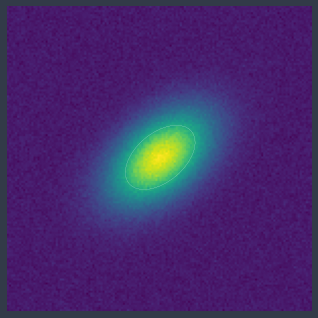

In [6]:
from photutils import EllipticalAperture
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma, geometry.sma*(1 - geometry.eps), geometry.pa)
plt.imshow(data, origin='lower')
aper.plot(color='white')
plt.axis('off')

In [7]:
from photutils.isophote import Ellipse
ellipse = Ellipse(data, geometry)

In [8]:
isolist = ellipse.fit_image()

In [9]:
print(isolist.to_table())

       sma                intens             intens_err      ... niter stop_code
                                                             ...                
------------------ -------------------- -------------------- ... ----- ---------
               0.0   102.74726639574224                  0.0 ...     0         0
0.5357666558053206   102.59918129896528 0.010452574213750008 ...    10         0
0.5893433213858527    102.5736795398143 0.010844446640538855 ...    13         0
 0.648277653524438   102.52264364492687 0.008489507827603675 ...    50         2
0.7131054188768818   102.22929888352353  0.07270251511701896 ...    16         0
0.7844159607645701    101.9811099748991   0.1000888918513494 ...    28         0
0.8628575568410272   102.02845198239255  0.08252452956658538 ...    23         0
  0.94914331252513   102.28181966590549  0.03710614379139965 ...    14         0
 1.044057643777643   102.30823658194734 0.025328869280833565 ...    12         0
1.1484634081554073   102.304

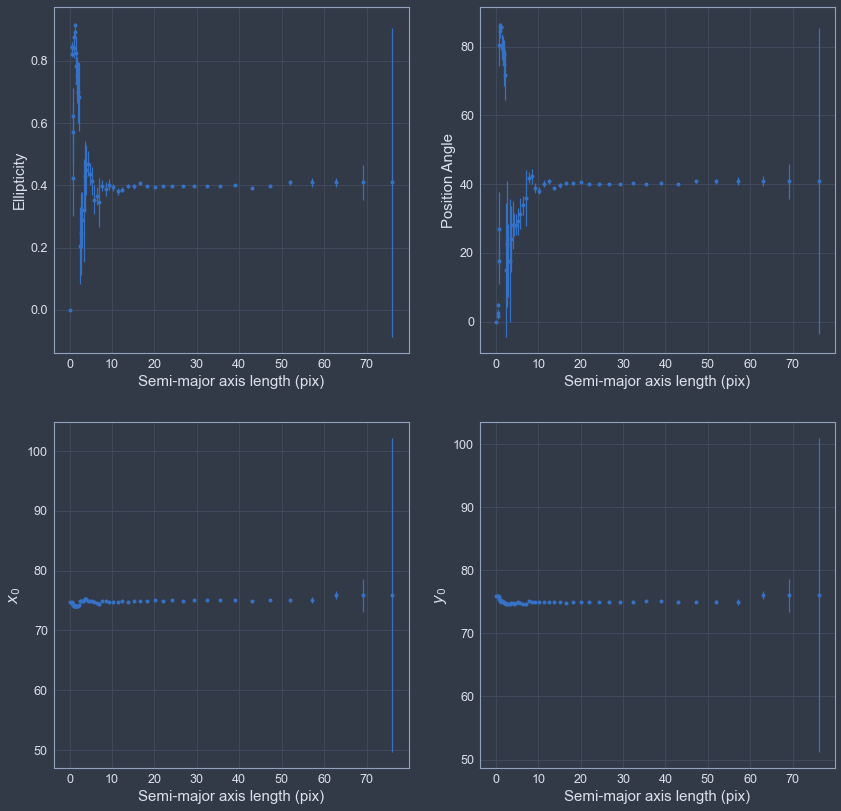

In [10]:
fig, axs = plt.subplots(2, 2,figsize=(14,14))
axs[0,0].errorbar(isolist.sma,isolist.eps,yerr=isolist.ellip_err,fmt='o', markersize=4)
axs[0,0].set_xlabel('Semi-major axis length (pix)', fontsize=15)
axs[0,0].set_ylabel('Ellipticity', fontsize=15)
axs[0,1].errorbar(isolist.sma,np.rad2deg(isolist.pa),yerr=np.rad2deg(isolist.pa_err),fmt='o', markersize=4)
axs[0,1].set_xlabel('Semi-major axis length (pix)', fontsize=15)
axs[0,1].set_ylabel('Position Angle', fontsize=15)
axs[1,0].errorbar(isolist.sma,isolist.x0,yerr=isolist.x0_err,fmt='o', markersize=4)
axs[1,0].set_xlabel('Semi-major axis length (pix)', fontsize=15)
axs[1,0].set_ylabel(r'$x_0$', fontsize=15)
axs[1,1].errorbar(isolist.sma,isolist.y0,yerr=isolist.y0_err,fmt='o', markersize=4)
axs[1,1].set_xlabel('Semi-major axis length (pix)', fontsize=15)
axs[1,1].set_ylabel(r'$y_0$', fontsize=15)
plt.show()

<font color='blue'>
<h1>In-class Exercise:</h1>

1) Build a two-component galaxy using fake_galaxy() to create two images and then combining them.  Use the same center.  Have one of the galaxy components be much smaller than the other.  And, for fun, have them rotated relative to each.
    
2) Run the isophotal analysis code on your new two-component galaxy.
</font>

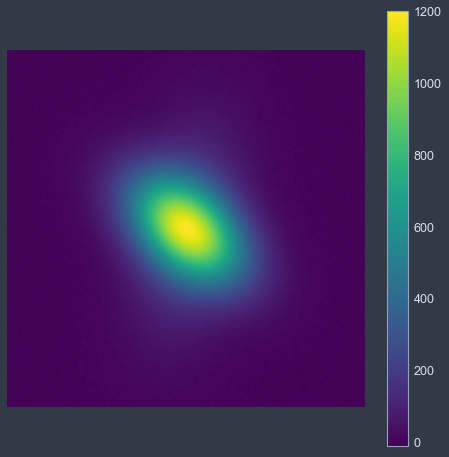

In [11]:
galaxy1 = fake_galaxy(75,75,1000.0,20,12,60)
galaxy2 = fake_galaxy(75,75,200.0,30,15,80)
galaxy_combo = galaxy1+galaxy2

galaxy1 = fake_galaxy(75,75,1000.0,20,12,40)
galaxy2 = fake_galaxy(75,75,200.0,30,15,100)
galaxy_combo = galaxy1+galaxy2

fig = plt.figure(figsize=(8,8))
plt.imshow(galaxy_combo, )
plt.colorbar()
plt.axis('off')
plt.show()

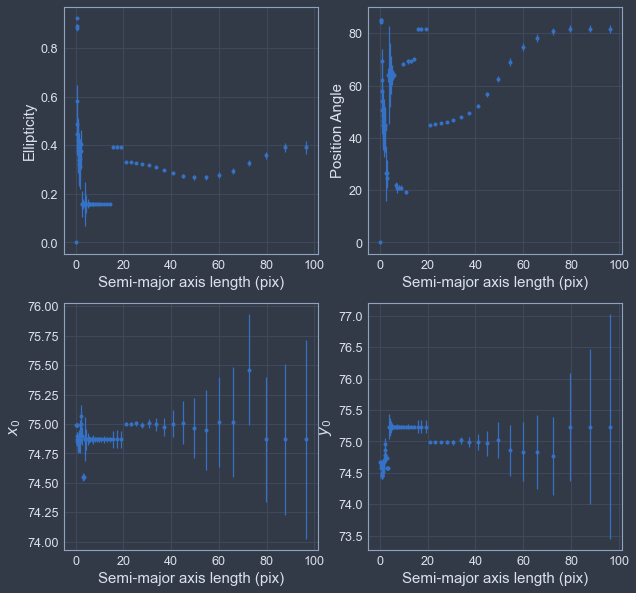

In [12]:
start = {'mnx':76.0, 'mny':74.0, 'asemi':21, 'bsemi':11, 'theta':50}
# start = {'mnx':51.0, 'mny':49.0, 'asemi':10, 'bsemi':11, 'theta':50}
# start = {'mnx':51.0, 'mny':49.0, 'asemi':50, 'bsemi':50, 'theta':50}

geometry_combo = EllipseGeometry(x0=start['mnx'], y0=start['mny'], sma=start['asemi'], eps=(start['asemi']-start['bsemi'])/start['asemi'], pa=np.deg2rad(start['theta']))
ellipse_combo = Ellipse(galaxy_combo, geometry_combo)
isolist = ellipse_combo.fit_image()

fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0,0].errorbar(isolist.sma,isolist.eps,yerr=isolist.ellip_err,fmt='o', markersize=4)
axs[0,0].set_xlabel('Semi-major axis length (pix)', fontsize=15)
axs[0,0].set_ylabel('Ellipticity', fontsize=15)
axs[0,1].errorbar(isolist.sma,np.rad2deg(isolist.pa),yerr=np.rad2deg(isolist.pa_err),fmt='o', markersize=4)
axs[0,1].set_xlabel('Semi-major axis length (pix)', fontsize=15)
axs[0,1].set_ylabel('Position Angle', fontsize=15)
axs[1,0].errorbar(isolist.sma,isolist.x0,yerr=isolist.x0_err,fmt='o', markersize=4)
axs[1,0].set_xlabel('Semi-major axis length (pix)', fontsize=15)
axs[1,0].set_ylabel(r'$x_0$', fontsize=15)
axs[1,1].errorbar(isolist.sma,isolist.y0,yerr=isolist.y0_err,fmt='o', markersize=4)
axs[1,1].set_xlabel('Semi-major axis length (pix)', fontsize=15)
axs[1,1].set_ylabel(r'$y_0$', fontsize=15)
plt.show()

## Build model from isophotes

In [13]:
from photutils.isophote import build_ellipse_model
model_image = build_ellipse_model(data.shape, isolist)
residual = data - model_image

(-0.5, 149.5, -0.5, 149.5)

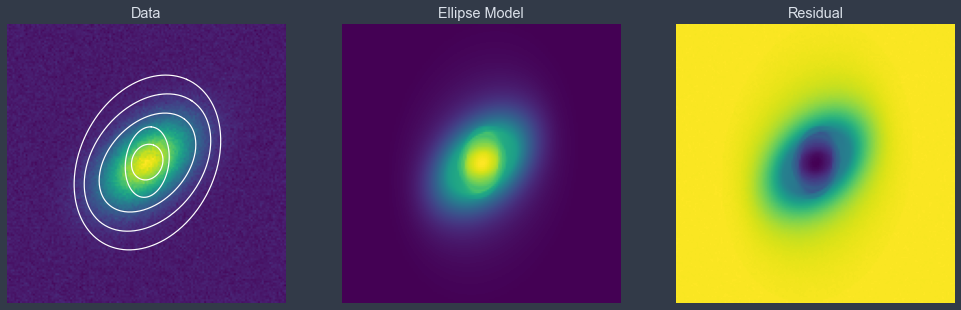

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
ax1.imshow(data, origin='lower')
ax1.set_title('Data')
ax1.axis('off')

smas = np.linspace(10, 50, 5)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax1.plot(x, y, color='white')

ax2.imshow(model_image, origin='lower')
ax2.set_title('Ellipse Model')
ax2.axis('off')

ax3.imshow(residual, origin='lower')
ax3.set_title('Residual')
ax3.axis('off')

<font color='blue'>
<h1>In-class Exercise:</h1>

1) Build a model of your two-component galaxy using the isophotes.
    
2) Make the three-panel comparison figure.
    
</font>

(-0.5, 149.5, -0.5, 149.5)

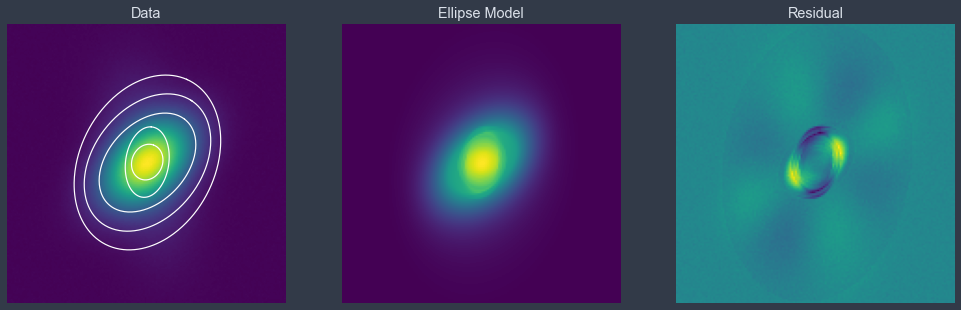

In [15]:
model_image = build_ellipse_model(galaxy_combo.shape, isolist)
residual = galaxy_combo - model_image

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
ax1.imshow(galaxy_combo, origin='lower')
ax1.set_title('Data')
ax1.axis('off')

smas = np.linspace(10, 50, 5)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax1.plot(x, y, color='white')

ax2.imshow(model_image, origin='lower')
ax2.set_title('Ellipse Model')
ax2.axis('off')

ax3.imshow(residual, origin='lower')
ax3.set_title('Residual')
ax3.axis('off')

# Deblending with Image Segmentation

In [27]:
from photutils.datasets import make_100gaussians_image
data = make_100gaussians_image()

(-0.5, 499.5, -0.5, 299.5)

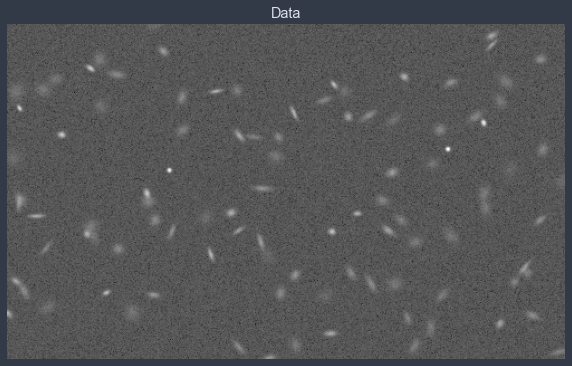

In [28]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig = plt.figure(figsize=(10, 12.5))
plt.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
plt.title('Data')
plt.axis('off')

In [29]:
from photutils import detect_threshold
threshold = detect_threshold(data, nsigma=2.)

In [30]:
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data, threshold, npixels=5, kernel=kernel)

(-0.5, 499.5, -0.5, 299.5)

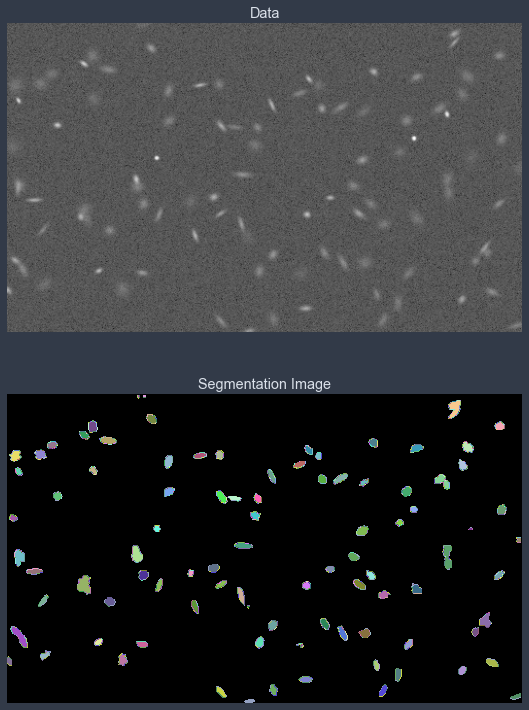

In [31]:
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
ax1.axis('off')
cmap = segm.make_cmap()
ax2.imshow(segm, origin='lower', cmap=cmap)
ax2.set_title('Segmentation Image')
ax2.axis('off')

<font color='blue'>
<h1>In-class Exercise:</h1>

1) Generate your own image of five galaxy that are spatially separated, but some are touching/overlapping.  Do this by generating five images with a large npix, make sure to offset their positions.  Then add them together.  
    
2) Segment the imag using ``detect_sources()``.
    
3) Plot the original image and segmentation map.
    
</font>

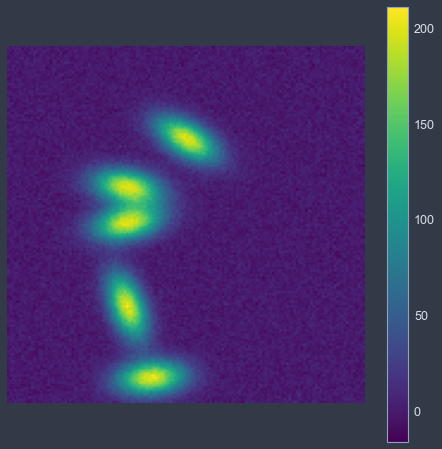

In [37]:
galaxy1 = fake_galaxy(75,110,200.0,5,10,60)
galaxy2 = fake_galaxy(50,75,200.0,5,10,100)
galaxy3 = fake_galaxy(50,40,200.0,5,10,200)
galaxy4 = fake_galaxy(50,90,200.0,5,10,80)
galaxy5 = fake_galaxy(60,10,200.0,5,10,95)
galaxy_combo = galaxy1+galaxy2+galaxy3+galaxy4+galaxy5

fig = plt.figure(figsize=(8,8))
plt.imshow(galaxy_combo, origin='lower')
plt.colorbar()
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Segmentation Image')

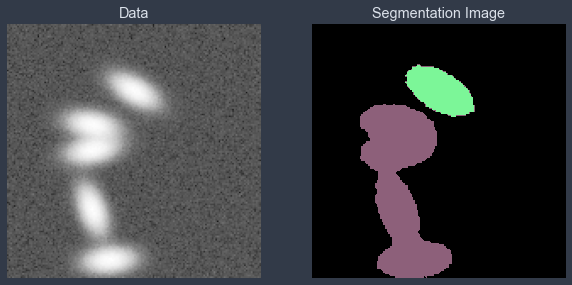

In [97]:
threshold = detect_threshold(galaxy_combo, nsigma=3.)
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(galaxy_combo, threshold, npixels=5, kernel=kernel)

norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,12.55))
ax1.imshow(galaxy_combo, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
ax1.axis('off')
cmap = segm.make_cmap()
ax2.imshow(segm, origin='lower', cmap=cmap)
ax2.axis('off')

ax2.set_title('Segmentation Image')

## Deblending the sources

In [32]:
from photutils import deblend_sources
segm_deblend = deblend_sources(data, segm, npixels=5,
                               kernel=kernel, nlevels=32,contrast=0.001)

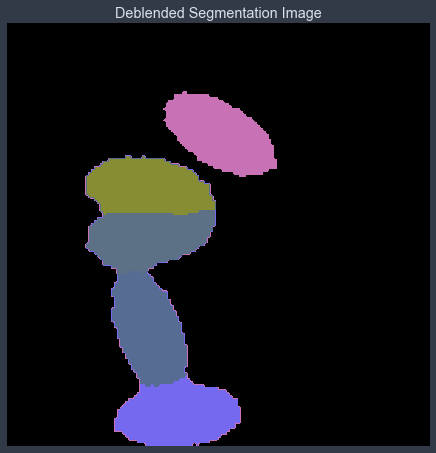

In [85]:
norm = ImageNormalize(stretch=SqrtStretch())
fig, ax = plt.subplots(1, 1, figsize=(10, 6.5))
cmap = segm_deblend.make_cmap()
ax.imshow(segm_deblend, origin='lower', cmap=cmap)
ax.set_title('Deblended Segmentation Image')
ax.axis('off')
plt.tight_layout()

<ipython-input-89-859f0ce5cd64>:7: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax2.imshow(segm.data[slc], origin='lower', cmap=cmap1)
<ipython-input-89-859f0ce5cd64>:7: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax2.imshow(segm.data[slc], origin='lower', cmap=cmap1)
<ipython-input-89-859f0ce5cd64>:11: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax3.imshow(segm_deblend.data[slc], origin='lower', cmap=cmap2)
<ipython-input-89-859f0ce5cd64>:11: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax3.imshow(segm_deblend.data[slc], origin='lower', cmap=cmap2)


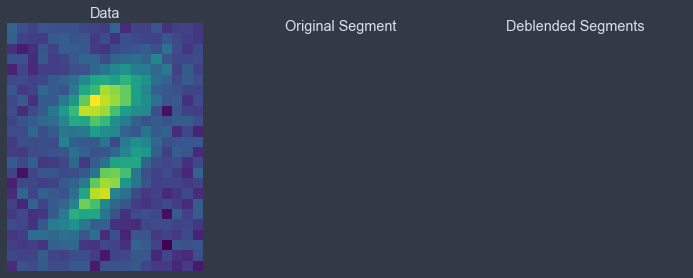

In [89]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
slc = (slice(273, 297), slice(425, 444))
ax1.imshow(data[slc], origin='lower')
ax1.set_title('Data')
ax1.axis('off')
cmap1 = segm.make_cmap()
ax2.imshow(segm.data[slc], origin='lower', cmap=cmap1)
ax2.set_title('Original Segment')
ax2.axis('off')
cmap2 = segm_deblend.make_cmap()
ax3.imshow(segm_deblend.data[slc], origin='lower', cmap=cmap2)
ax3.set_title('Deblended Segments')
ax3.axis('off')
plt.tight_layout()



<font color='blue'>
<h1>In-class Exercise:</h1>

1) Now deblend the sources using ``deblend_sources()``.
    
2) Make the three-panel figures showing the original data, segmented map and deblended map.
    
</font>

(-0.5, 149.5, -0.5, 149.5)

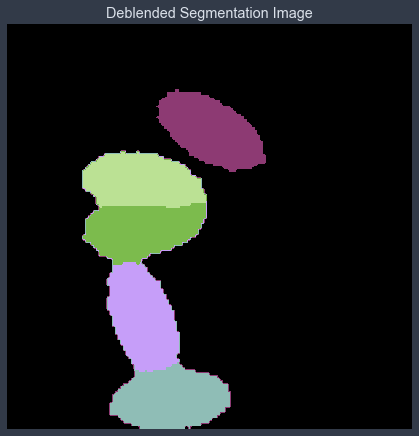

In [90]:
segm_deblend = deblend_sources(galaxy_combo, segm, npixels=5,
                               kernel=kernel, nlevels=32,contrast=0.001)
norm = ImageNormalize(stretch=SqrtStretch())
fig, ax = plt.subplots(1, 1, figsize=(10, 6.5))
cmap = segm_deblend.make_cmap()
ax.imshow(segm_deblend, origin='lower', cmap=cmap)
ax.set_title('Deblended Segmentation Image')
plt.tight_layout()
ax.axis('off')


(-0.5, 149.5, -0.5, 149.5)

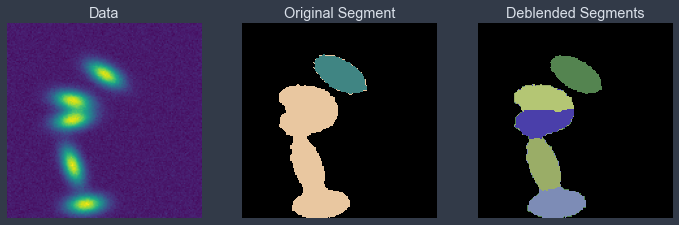

In [91]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
slc = (slice(273, 297), slice(425, 444))
ax1.imshow(galaxy_combo, origin='lower')
ax1.set_title('Data')
cmap1 = segm.make_cmap()
ax2.imshow(segm, origin='lower', cmap=cmap1)
ax2.set_title('Original Segment')
cmap2 = segm_deblend.make_cmap()
ax3.imshow(segm_deblend, origin='lower', cmap=cmap2)
ax3.set_title('Deblended Segments')
plt.tight_layout()
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
